In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

## Extracting useful patterns from z_style

### Glasses

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # For 2D visualization of the latent space
from torchvision.utils import make_grid

# Local imports
from classification_multi.model import CCVAE
from classification_multi.dataset import CartoonMultiLabelDataset
from torchvision import transforms

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_PATH = (
    PROJECT_ROOT
    / "classification_multi"
    / "model_weights"
    / "ccvae_multilabel_new.pth"
)

DATA_DIR = (
    PROJECT_ROOT
    / "data"
    / "cartoonset10k"
    / "cartoonset10k"
)

# Use a large batch size to get many points for t-SNE
BATCH_SIZE = 128

print(f"Working on {DEVICE}")


Working on cuda


In [3]:
# Dataset & Loader
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
dataset = CartoonMultiLabelDataset(root_dir=DATA_DIR, transform=transform,target_attributes=["hair_color", "face_color"])
test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Loading labels for attributes: ['hair_color', 'face_color'] ...
Dataset loaded successfully. Attribute dimensions: {'hair_color': 10, 'face_color': 11}


In [4]:
# Load the model
Z_C_DIMS = [16, 16]
Z_NOT_C_DIM = 32

model_multi = CCVAE(
    img_channels=3,
    z_c_dims=Z_C_DIMS,        # List [16, 16], one latent block per attribute
    z_not_c_dim=Z_NOT_C_DIM,  # Shared nuisance / style latent dimension
    num_classes_list=[10, 11]
).to(DEVICE)
state = torch.load(MODEL_PATH, map_location=DEVICE)

# new_state = {}
# for k, v in state.items():
#     k_new = k
#     k_new = k_new.replace("priors_embedding", "prior_embeddings")
#     k_new = k_new.replace("priors_mu", "prior_mu")
#     k_new = k_new.replace("priors_logvar", "prior_logvar")
#     new_state[k_new] = v
# missing, unexpected = model_multi.load_state_dict(new_state, strict=False)
missing, unexpected = model_multi.load_state_dict(state, strict=False)

model_multi.eval()

/tmp/ipykernel_1742232/152101983.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MODEL_PATH, map_location=DEVICE)


CCVAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=1024, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=1024, out_features=64, bias=True)
  (decoder_input): Linear(in_features=64, out_features=1024, bias=True)
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspo

In [5]:
#utils multi
def encode_to_z(model, x):
    """
    x : (1, 3, 64, 64)

    Returns:
        z : (1, total_dim) - Full latent vector
        z_c_list : [tensor(1, 16), tensor(1, 16)] - List of attribute-specific latents
        z_not_c : (1, 32) - Unsupervised / style latent
    """
    with torch.no_grad():
        h = model.encoder_conv(x)
        mu = model.fc_mu(h)

        # We use the deterministic mean (mu) for analysis and inference
        # Sampling via reparameterization can be used if desired
        z = mu

        # Split the latent vector into attribute-specific and nuisance parts
        split_sizes = model.z_c_dims + [model.z_not_c_dim]
        z_parts = torch.split(z, split_sizes, dim=1)

        z_c_list = z_parts[:-1]  # List of z_c_i
        z_not_c = z_parts[-1]    # Nuisance / style latent

    return z, z_c_list, z_not_c


def probas_from_zc(model, z_c_list):
    """
    z_c_list : List of tensors [z_c_hair, z_c_face]

    Returns:
        probs_list : List of probability tensors [(1, 10), (1, 11)]
    """
    probs_list = []
    with torch.no_grad():
        for i, z_c_i in enumerate(z_c_list):
            logits = model.classifiers[i](z_c_i)
            probs = F.softmax(logits, dim=1)
            probs_list.append(probs)
    return probs_list


def classify_x(model, x):
    """
    x : (1, 3, 64, 64)

    Returns:
        preds : List of predicted class indices [pred_hair, pred_face]
        probs_list : List of probability tensors
    """
    _, z_c_list, _ = encode_to_z(model, x)
    probs_list = probas_from_zc(model, z_c_list)

    preds = []
    for probs in probs_list:
        pred_item = torch.argmax(probs, dim=1).item()
        preds.append(pred_item)

    return preds, probs_list


def generate_random(model, device="cuda"):
    """
    Generate a completely random image by sampling all latent variables.
    """
    with torch.no_grad():
        z_parts = []

        # 1. Random sampling for attribute latents (z_c)
        for dim in model.z_c_dims:
            z_parts.append(torch.randn(1, dim, device=device))

        # 2. Random sampling for nuisance / style latent (z_not_c)
        z_parts.append(torch.randn(1, model.z_not_c_dim, device=device))

        # 3. Concatenate and decode
        z = torch.cat(z_parts, dim=1)
        dec = model.decoder_input(z).view(-1, 64, 4, 4)
        x_gen = model.decoder_conv(dec)

    return x_gen


def generate_conditional(model, class_idxs, device="cuda"):
    """
    Generate an image conditioned on specific attribute classes.

    Args:
        class_idxs : List of class indices [idx_hair, idx_face]
                     Example: [0, 5] -> Hair class 0, Face class 5
    """
    with torch.no_grad():
        z_parts = []

        # For each attribute, generate the corresponding z_c via its conditional prior
        for i, class_idx in enumerate(class_idxs):
            y = torch.tensor([class_idx], device=device)
            num_cls = model.num_classes_list[i]
            y_onehot = F.one_hot(y, num_classes=num_cls).float()

            # Prior network: one-hot -> embedding -> mean
            embed = F.relu(model.prior_embeddings[i](y_onehot))
            mu_prior = model.prior_mu[i](embed)

            # Use the prior mean as the class prototype
            z_parts.append(mu_prior)

        # Add random nuisance / style latent
        z_parts.append(torch.randn(1, model.z_not_c_dim, device=device))

        # Concatenate and decode
        z = torch.cat(z_parts, dim=1)
        dec = model.decoder_input(z).view(-1, 64, 4, 4)
        x_gen = model.decoder_conv(dec)

    return x_gen


def show_tensor_image(
    img_tensor,
    title=None,
    figsize=(2.5, 2.5),
    dpi=300,
    save_path=None,
    ax=None,
):
    """
    Display a single image tensor.

    Args:
        img_tensor (Tensor): Image tensor of shape (1, C, H, W) or (C, H, W)
        title (str, optional): Figure title
        figsize (tuple): Figure size in inches
        dpi (int): Resolution for publication-quality rendering
        save_path (str, optional): If provided, saves the figure to this path
        ax (matplotlib.axes.Axes, optional): Axis to draw on (for grids / subplots)

    Returns:
        fig, ax : Matplotlib figure and axis objects
    """
    # Convert tensor to numpy image
    img = img_tensor.detach().cpu()
    if img.dim() == 4:
        img = img.squeeze(0)

    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0.0, 1.0)

    # Create figure if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    else:
        fig = ax.figure

    ax.imshow(img)
    ax.axis("off")

    if title is not None:
        ax.set_title(title, fontsize=10)

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=dpi,
            bbox_inches="tight",
            pad_inches=0.0,
        )

    return fig, ax


### Classifier z_c, z_style ==> Glasses

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import xgboost as xgb

def run_glasses_probe(probe_dataset,model, data_dir, device='cuda', sample_limit=2000, use_xgboost=False):
    print(f"--- Starting Probe: Unsupervised Glasses Detection (Mode: {'XGBoost' if use_xgboost else 'Logistic Regression'}) ---")
    
    probe_loader = DataLoader(probe_dataset, batch_size=64, shuffle=True)
    
    print(f"Extracting latent vectors from {sample_limit} images...")
    
    X_style = []      # z_not_c (Unsupervised Style)
    X_content = []    # z_c (Supervised Color)
    y_ground_truth = []  # True Label: Wearing Glasses (1) or Not (0)
    
    model.eval()
    samples_collected = 0
    
    with torch.no_grad():
        for x, labels in probe_loader:
            x = x.to(device)
            
            # labels shape is [Batch, 3] -> [hair, face, glasses]
            # Column 2 is "glasses"
            glasses_indices = labels[:, 2].cpu().numpy()
            
            # 2. Define the Target
            # User info: Class 11 means "No Glasses". 
            # Logic: If index is NOT 11, then they ARE wearing glasses (1).
            is_wearing_glasses = (glasses_indices != 11).astype(int)
            
            # 3. Extract Latents
            # We use the 'encode_to_z' function defined in your previous block
            _, z_c_list, z_not_c = encode_to_z(model, x)
            
            # z_not_c is the style (1, 32)
            # z_c_list is [hair(16), face(16)]. We concat them to see if ANY color info leaked.
            z_c_concat = torch.cat(z_c_list, dim=1).cpu().numpy()
            
            X_style.append(z_not_c.cpu().numpy())
            X_content.append(z_c_concat)
            y_ground_truth.append(is_wearing_glasses)
            
            samples_collected += x.size(0)
            if samples_collected >= sample_limit:
                break
    
    # Concatenate lists into numpy arrays
    X_style = np.concatenate(X_style)[:samples_collected]
    X_content = np.concatenate(X_content)[:samples_collected]
    y_ground_truth = np.concatenate(y_ground_truth)[:samples_collected]
    
    print(f"Data extracted: {len(y_ground_truth)} samples.")
    print(f"Glasses prevalence: {y_ground_truth.mean():.1%}")

    # 4. Train Probes
    print("\nTraining Classifiers...")
    
    # Helper to train and evaluate
    def train_evaluate(X, y, name):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        if use_xgboost:
            # clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
            clf = xgb.XGBClassifier(eval_metric='logloss')
        else:
            clf = LogisticRegression(max_iter=1000, class_weight='balanced')
            
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        return acc, clf

    # --- Probe A: Style Vector (z_not_c) ---
    acc_style, clf_style = train_evaluate(X_style, y_ground_truth, "Style")
    
    # --- Probe B: Color Vector (z_c) - Control ---
    acc_content, _ = train_evaluate(X_content, y_ground_truth, "Color")
    
    # 5. Report Results
    print("\n" + "="*40)
    print("ROBE RESULTS")
    print("="*40)
    print(f"Feature: GLASSES")
    print(f"Model: {'XGBoost (Non-linear)' if use_xgboost else 'Logistic Regression (Linear)'}")
    print(f"----------------------------------------")
    print(f"Accuracy on Style Vector (z_not_c):   {acc_style:.2%}")
    print(f"Accuracy on Color Vector (z_c):       {acc_content:.2%}")
    print("="*40)
    
    results = {
        'Style': acc_style,
        'Color': acc_content
    }
    
    return clf_style,results

# 1. Setup a specific Probe Dataset
# We MUST reload the dataset to get the "glasses" attribute from the CSVs.
print("Lazy loading dataset metadata for probe...")
probe_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# We request "glasses" specifically
probe_dataset = CartoonMultiLabelDataset(
    root_dir=DATA_DIR, 
    target_attributes=["hair_color", "face_color", "glasses"], 
    transform=probe_transform
)
# --- RUN EXPERIMENT ---
# 1. Linear Probe (Good for surgery)
linear_clf,res_linear = run_glasses_probe(probe_dataset,model_multi, DATA_DIR, DEVICE, sample_limit=2000, use_xgboost=False)

# 2. Non-Linear Probe (Good for checking max capacity)
xgb_clf,res_xgb = run_glasses_probe(probe_dataset,model_multi, DATA_DIR, DEVICE, sample_limit=2000, use_xgboost=True)

Lazy loading dataset metadata for probe...
Loading labels for attributes: ['hair_color', 'face_color', 'glasses'] ...
Dataset loaded successfully. Attribute dimensions: {'hair_color': 10, 'face_color': 11, 'glasses': 12}
--- Starting Probe: Unsupervised Glasses Detection (Mode: Logistic Regression) ---
Extracting latent vectors from 2000 images...
Data extracted: 2048 samples.
Glasses prevalence: 49.6%

Training Classifiers...

ROBE RESULTS
Feature: GLASSES
Model: Logistic Regression (Linear)
----------------------------------------
Accuracy on Style Vector (z_not_c):   63.90%
Accuracy on Color Vector (z_c):       66.59%
--- Starting Probe: Unsupervised Glasses Detection (Mode: XGBoost) ---
Extracting latent vectors from 2000 images...


/users/eleves-a/2022/rida.assalouh/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Data extracted: 2048 samples.
Glasses prevalence: 48.3%

Training Classifiers...

ROBE RESULTS
Feature: GLASSES
Model: XGBoost (Non-linear)
----------------------------------------
Accuracy on Style Vector (z_not_c):   64.63%
Accuracy on Color Vector (z_c):       67.07%


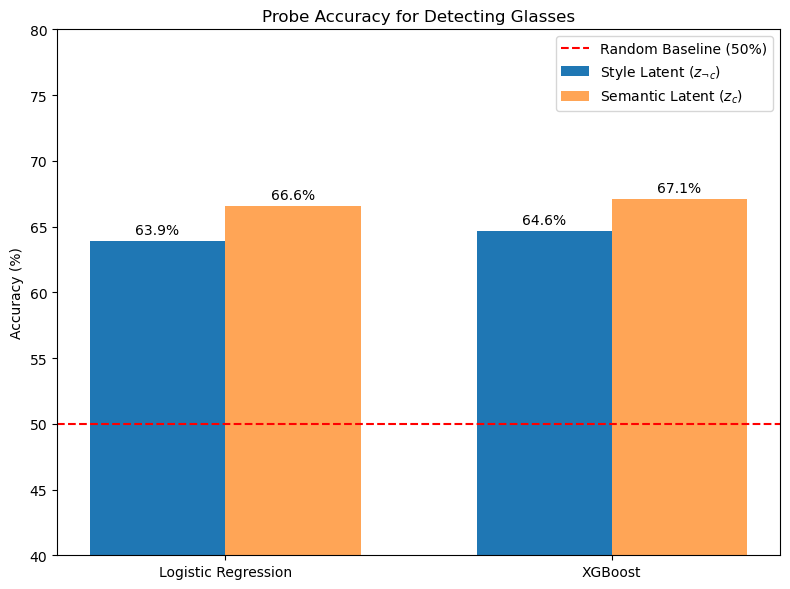

In [7]:
def plot_probe_results(results_dict):
    """
    Visualization of linear and non-linear probe results.

    This plot compares the predictive performance of probes trained on:
      - the nuisance/style latent vector z_{¬c}
      - the semantic/color latent vector z_c

    The goal is to assess whether a non-target attribute (e.g. glasses)
    leaks into the semantic or nuisance subspaces.
    """
    model_names = list(results_dict.keys())  # e.g. ['Logistic Regression', 'XGBoost']
    style_scores = [results_dict[m]["Style"] * 100.0 for m in model_names]
    color_scores = [results_dict[m]["Color"] * 100.0 for m in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 6))

    bars_style = ax.bar(
        x - width / 2,
        style_scores,
        width,
        label=r"Style Latent ($z_{\neg c}$)",
        color="#1f77b4",
    )
    bars_color = ax.bar(
        x + width / 2,
        color_scores,
        width,
        label=r"Semantic Latent ($z_c$)",
        color="#ff7f0e",
        alpha=0.7,
    )

    # Random-guess baseline (binary attribute)
    ax.axhline(
        y=50.0,
        color="red",
        linestyle="--",
        label="Random Baseline (50%)",
    )

    ax.set_ylabel("Accuracy (%)")
    ax.set_title("Probe Accuracy for Detecting Glasses")
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylim(40, 80)
    ax.legend()

    # Annotate bars with numerical values
    def annotate_bars(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(
                f"{height:.1f}%",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha="center",
                va="bottom",
            )

    annotate_bars(bars_style)
    annotate_bars(bars_color)

    fig.tight_layout()
    plt.show()

all_results = {
    "Logistic Regression": res_linear,
    "XGBoost": res_xgb,
}

plot_probe_results(all_results)


### Extract Glasses

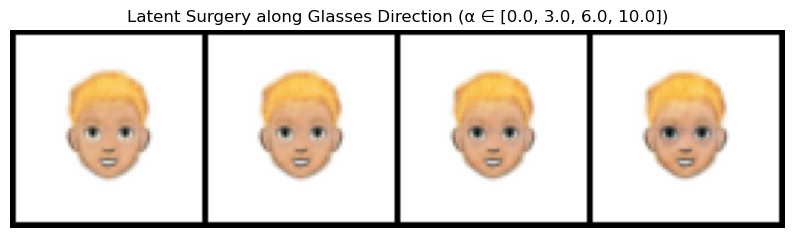

In [8]:
def latent_surgery(model, clf, data_loader, device="cuda"):
    """
    Latent space intervention via linear probe directions.

    This experiment applies a controlled intervention along the
    "glasses" direction learned by a linear classifier trained on
    the nuisance latent z_{¬c}. The goal is to assess whether adding
    this direction induces the targeted attribute while preserving
    semantic content.
    """
    model.eval()

    # Direction corresponding to the "glasses" attribute
    glasses_vector = torch.tensor(clf.coef_[0], dtype=torch.float32).to(device)
    glasses_vector = glasses_vector / torch.norm(glasses_vector)

    # Select an image without glasses
    target_img = None
    with torch.no_grad():
        for x, labels in data_loader:
            no_glasses_mask = labels[:, 2] == 11  # class index for "no glasses"
            if no_glasses_mask.any():
                target_img = x[no_glasses_mask][:1].to(device)
                break

    if target_img is None:
        print("No image without glasses found.")
        return

    # Encode image
    _, z_c_list, z_not_c = encode_to_z(model, target_img)

    # Apply latent intervention with increasing strength
    alphas = [0.0, 3.0, 6.0, 10.0]
    generated = []

    with torch.no_grad():
        for alpha in alphas:
            z_not_c_mod = z_not_c + alpha * glasses_vector
            z_full = torch.cat(list(z_c_list) + [z_not_c_mod], dim=1)

            dec = model.decoder_input(z_full).view(-1, 64, 4, 4)
            img = model.decoder_conv(dec)
            generated.append(img.cpu())

    # Visualization
    grid = make_grid(torch.cat(generated), nrow=len(alphas), padding=2)
    plt.figure(figsize=(10, 4))
    plt.imshow(grid.permute(1, 2, 0).clamp(0, 1))
    plt.title(f"Latent Surgery along Glasses Direction (α ∈ {alphas})")
    plt.axis("off")
    plt.show()

surgery_loader = DataLoader(probe_dataset, batch_size=32, shuffle=True)
latent_surgery(model_multi, linear_clf, surgery_loader, device=DEVICE)


### Chin length

=== Experiment: Latent Correlation Heatmap ===
Loading labels for attributes: ['chin_length', 'eye_angle', 'eye_lashes', 'eye_lid', 'eyebrow_weight', 'eyebrow_thickness', 'face_shape', 'eye_slant', 'eyebrow_width', 'eye_eyebrow_distance'] ...
Dataset loaded successfully. Attribute dimensions: {'chin_length': 3, 'eye_angle': 3, 'eye_lashes': 2, 'eye_lid': 2, 'eyebrow_weight': 2, 'eyebrow_thickness': 4, 'face_shape': 7, 'eye_slant': 3, 'eyebrow_width': 3, 'eye_eyebrow_distance': 3}


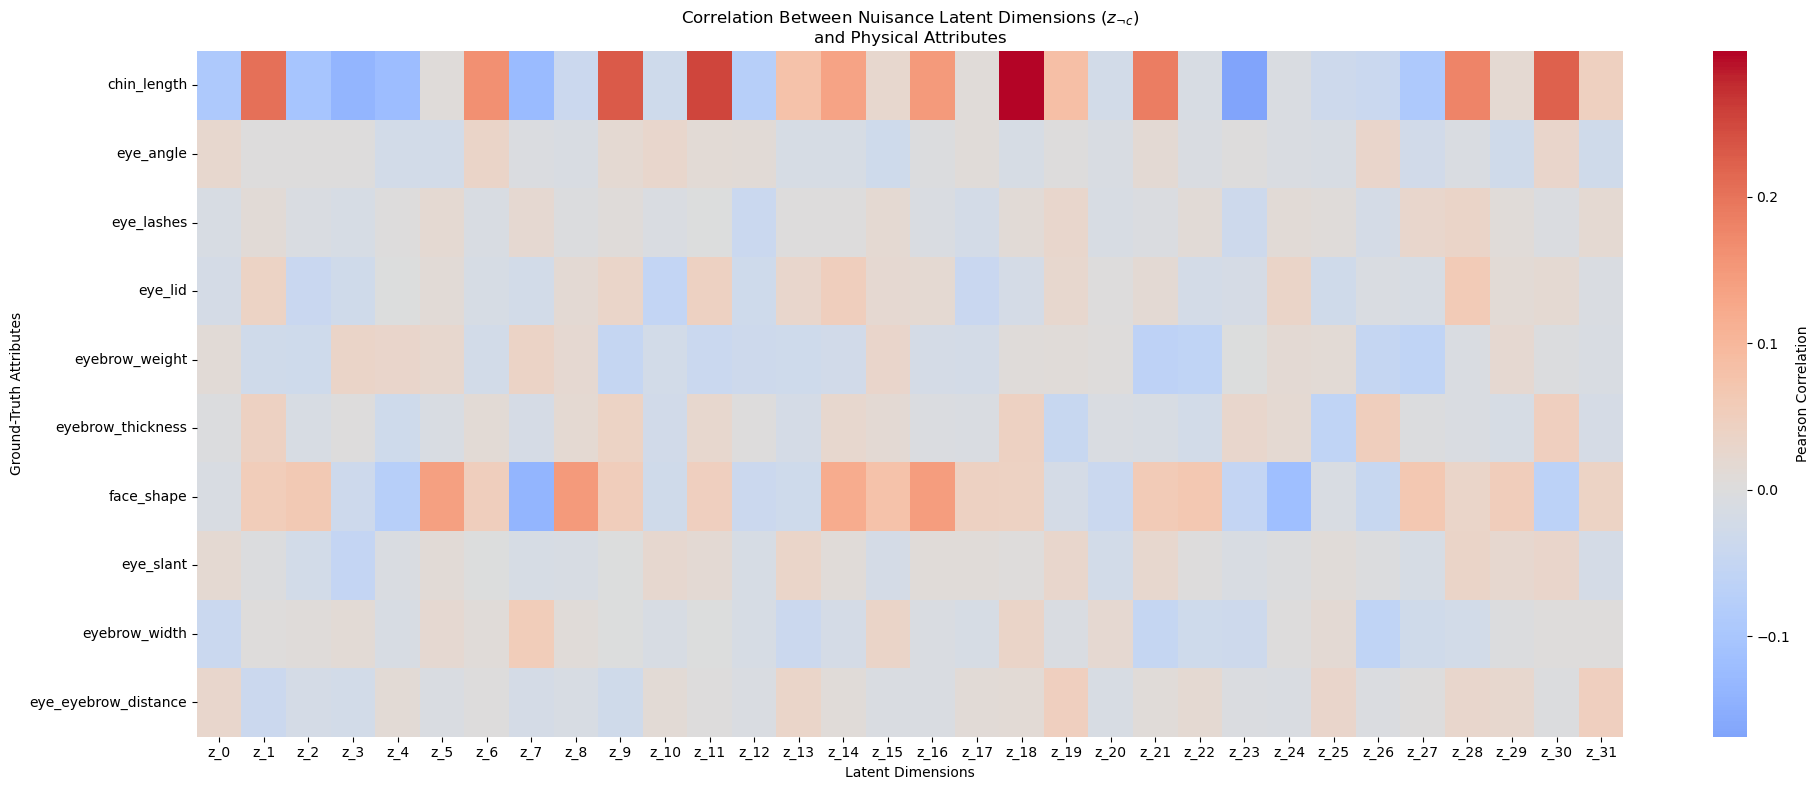

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def experiment_latent_correlation(
    model,
    data_dir,
    device="cuda",
    sample_limit=2000,
):
    """
    Correlation analysis between nuisance latent dimensions z_{¬c}
    and continuous / ordinal ground-truth attributes.

    This experiment evaluates whether unsupervised latent neurons
    encode interpretable physical attributes by measuring Pearson
    correlations between z_{¬c} and selected attributes.
    """
    print("=== Experiment: Latent Correlation Heatmap ===")

    # Attributes of interest
    interesting_attributes = [
        "chin_length",
        "eye_angle",
        "eye_lashes",
        "eye_lid",
        "eyebrow_weight",
        "eyebrow_thickness",
        "face_shape",
        "eye_slant",
        "eyebrow_width",
        "eye_eyebrow_distance",
    ]

    probe_transform = transforms.Compose(
        [transforms.Resize((64, 64)), transforms.ToTensor()]
    )

    probe_dataset = CartoonMultiLabelDataset(
        root_dir=data_dir,
        target_attributes=interesting_attributes,
        transform=probe_transform,
    )
    probe_loader = DataLoader(probe_dataset, batch_size=64, shuffle=True)

    latent_vectors = []
    attribute_vectors = []

    model.eval()
    samples_collected = 0

    with torch.no_grad():
        for x, labels in probe_loader:
            x = x.to(device)

            _, _, z_not_c = encode_to_z(model, x)
            latent_vectors.append(z_not_c.cpu().numpy())
            attribute_vectors.append(labels.cpu().numpy())

            samples_collected += x.size(0)
            if samples_collected >= sample_limit:
                break

    Z = np.concatenate(latent_vectors)[:samples_collected]
    A = np.concatenate(attribute_vectors)[:samples_collected]

    z_columns = [f"z_{i}" for i in range(Z.shape[1])]
    df_z = pd.DataFrame(Z, columns=z_columns)
    df_attr = pd.DataFrame(A, columns=interesting_attributes)

    full_df = pd.concat([df_z, df_attr], axis=1)
    corr = full_df.corr()

    cross_corr = corr.loc[interesting_attributes, z_columns]

    # Visualization
    plt.figure(figsize=(20, 8))
    sns.heatmap(
        cross_corr,
        cmap="coolwarm",
        center=0.0,
        cbar_kws={"label": "Pearson Correlation"},
        annot=False,
    )
    plt.title(
        "Correlation Between Nuisance Latent Dimensions ($z_{\\neg c}$)\n"
        "and Physical Attributes"
    )
    plt.xlabel("Latent Dimensions")
    plt.ylabel("Ground-Truth Attributes")
    plt.tight_layout()
    plt.show()

    return cross_corr


# Example usage
correlation_df = experiment_latent_correlation(model_multi, DATA_DIR, device=DEVICE)


=== Latent Surgery: Chin Length (Neuron 22) ===
Loading labels for attributes: ['hair_color'] ...
Dataset loaded successfully. Attribute dimensions: {'hair_color': 10}


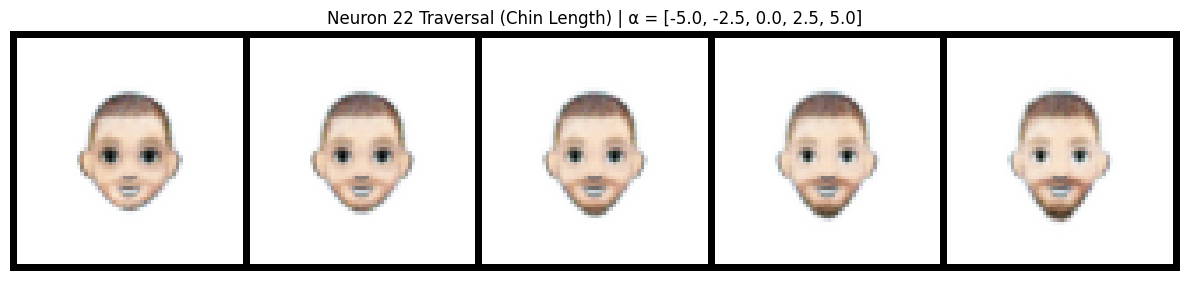

In [ ]:
def surgery_chin_length(model, data_dir, device="cuda"):
    """
    Latent surgery along a single nuisance dimension (neuron 22),
    identified as correlated with chin length.
    """
    print("=== Latent Surgery: Chin Length (Neuron 22) ===")

    transform = transforms.Compose(
        [transforms.Resize((64, 64)), transforms.ToTensor()]
    )

    dataset = CartoonMultiLabelDataset(
        root_dir=data_dir,
        target_attributes=["hair_color"],  # minimal loading
        transform=transform,
    )
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Unit direction targeting neuron 22 in z_{¬c}
    feature_vector = torch.zeros((1, model.z_not_c_dim), device=device)
    feature_vector[0, 22] = 1.0

    # Select a reference image
    target_img, _ = next(iter(loader))
    target_img = target_img[0:1].to(device)

    # Encode
    _, z_c_list, z_not_c = encode_to_z(model, target_img)

    # Latent manipulation
    alphas = [-5.0, -2.5, 0.0, 2.5, 5.0]
    results = []

    for alpha in alphas:
        z_not_c_new = z_not_c + alpha * feature_vector
        z_combined = torch.cat(list(z_c_list) + [z_not_c_new], dim=1)

        dec_in = model.decoder_input(z_combined).view(-1, 64, 4, 4)
        recon = model.decoder_conv(dec_in)
        results.append(recon.cpu())

    # Visualization
    grid = make_grid(torch.cat(results), nrow=len(alphas), padding=2)
    plt.figure(figsize=(12, 4))
    plt.imshow(grid.permute(1, 2, 0).clip(0, 1))
    plt.title(f"Neuron 22 Traversal (Chin Length) | α = {alphas}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Example usage
surgery_chin_length(model_multi, DATA_DIR, device=DEVICE)


## Probing experiments

### Regressor z_style ==> age

In [ ]:
from PIL import Image

from regression.model import CCVAE_Age
from regression.dataset import UTKFaceDataset
from torchvision import transforms

# --- CONFIGURATION ---
MODEL_REG_PATH = PROJECT_ROOT / "regression" / "model_weights" / "ccvae_age_balanced.pth"
DATA_REG_DIR = PROJECT_ROOT / "data" / "UTKFace"

Z_C_DIM_REG = 16           
Z_NOT_C_DIM_REG = 64       

# --- LOAD DATA & MODEL ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset_reg = UTKFaceDataset(root_dir=DATA_REG_DIR, transform=transform)
dataloader_reg = DataLoader(dataset_reg, batch_size=8, shuffle=True)

model_reg = CCVAE_Age(
        img_channels=3,
        z_c_dim=Z_C_DIM_REG,
        z_not_c_dim=Z_NOT_C_DIM_REG
    ).to(DEVICE)
model_reg.load_state_dict(torch.load(MODEL_REG_PATH, map_location=DEVICE))
model_reg.eval()
print("Loaded model !")


UTKFace dataset loaded: 23708 images.
Loaded model !


Dataset created: X=(20000, 64), y=(20000,)
=== Leakage Probe Results ===
R² score: 0.1940
MAE: 14.20 years
RMSE: 18.33 years


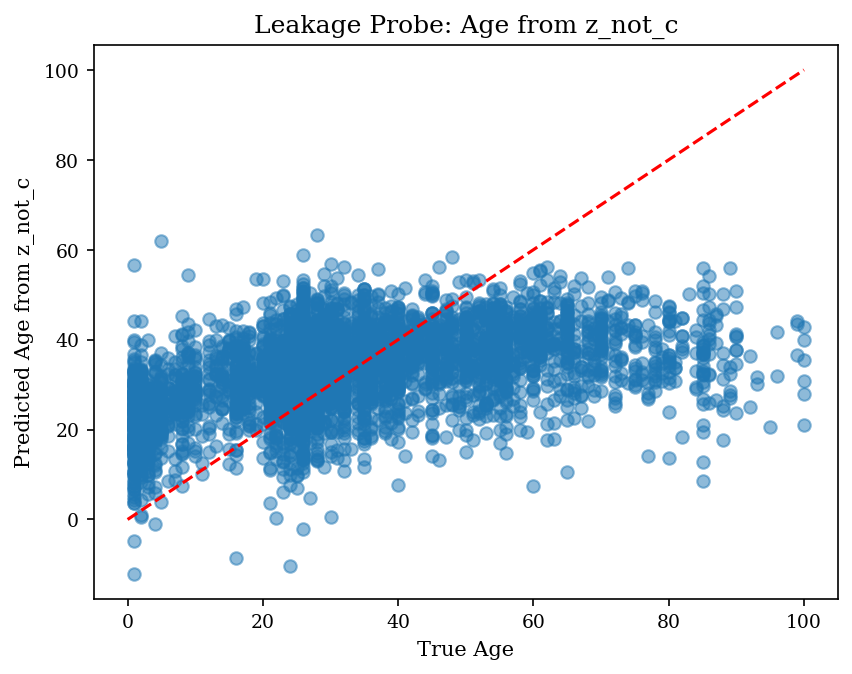

In [ ]:

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# --- EXTRACT Z_not_c FEATURES AND AGE TARGETS ---
all_z_not_c = []
all_ages = []

num_images = 0
max_images = 20000

with torch.no_grad():
    for imgs, ages_norm in dataloader_reg:
        # Move to device
        imgs = imgs.to(DEVICE)
        ages = ages_norm.squeeze() * 100
        
        # Forward pass
        recon, mu, _, pred_age_norm, _, _ = model_reg(imgs)
        z_not_c_batch = mu[:, Z_C_DIM_REG:]
        
        all_z_not_c.append(z_not_c_batch.cpu().numpy())
        all_ages.append(ages.cpu().numpy())
        
        # Count images
        num_images += imgs.size(0)
        if num_images >= max_images:
            break

# Stack everything
X = np.vstack(all_z_not_c)  # shape: [num_samples, Z_NOT_C_DIM]
y = y = np.concatenate(all_ages)     # shape: [num_samples]

print(f"Dataset created: X={X.shape}, y={y.shape}")

# --- SPLIT TRAIN/TEST ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- TRAIN REGRESSOR ---
regressor = LinearRegression()
# Optional: use Ridge if you want some regularization
# regressor = Ridge(alpha=1.0)

regressor.fit(X_train, y_train)

# --- EVALUATE ---
y_pred = regressor.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("=== Leakage Probe Results ===")
print(f"R² score: {r2:.4f}")
print(f"MAE: {mae:.2f} years")
print(f"RMSE: {rmse:.2f} years")


plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("True Age")
plt.ylabel("Predicted Age from z_not_c")
plt.title("Leakage Probe: Age from z_not_c")
plt.plot([0, 100], [0, 100], 'r--')  # perfect prediction line
plt.show()

### How to solve this problem? Contrastive loss!

In [ ]:
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import sys
from pathlib import Path
from classification_mono.model_contrastive import CCVAE

MODEL_PATH_CONTRASTIVE = "../classification_mono/model_weights/ccvae_haircolor_contrastive.pth" 
SAMPLE_LIMIT = 2000  # Number of images for the test

# The attributes we want to test
PROBE_ATTRIBUTES = ["hair_color", "glasses", "face_shape", "face_color"]

print(f"--- Starting Leakage Audit on {DEVICE} ---")

class CartoonProbeDataset(Dataset):
    """Dataset for loading CartoonSet images and their probe labels."""
    def __init__(self, root_dir, target_attributes, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_attributes = target_attributes
        
        # List images
        self.images = sorted([f for f in os.listdir(root_dir) if f.endswith(".png")])
        self.labels_dict = {attr: [] for attr in target_attributes}
        
        print(f"Lazy loading labels for {target_attributes}...")
        
        count = 0
        
        # Loop to read CSVs and build label dict
        for img_file in self.images:
            if count >= SAMPLE_LIMIT:
                break
                
            csv_file = img_file.replace(".png", ".csv")
            csv_path = os.path.join(root_dir, csv_file)
            
            try:
                df = pd.read_csv(csv_path, header=None)
                valid_image = True
                
                # Check for all target attributes in the current CSV
                for attr in target_attributes:
                    row = df[df.iloc[:, 0] == attr]
                    if not row.empty:
                        val = int(row.iloc[0, 1])
                        self.labels_dict[attr].append(val)
                    else:
                        valid_image = False
                        # Remove last appended labels if we decide this image is incomplete
                        for cleanup_attr in target_attributes:
                            if cleanup_attr in self.labels_dict and len(self.labels_dict[cleanup_attr]) > count:
                                self.labels_dict[cleanup_attr].pop()
                        break
                
                if valid_image:
                    count += 1
            except Exception:
                pass # Ignore images without a corresponding CSV
                
        # Trim the images list to match the count of loaded labels
        self.images = self.images[:count]
        # Re-check and trim labels_dict just in case of edge errors
        min_len = len(self.images)
        for attr in target_attributes:
             self.labels_dict[attr] = self.labels_dict[attr][:min_len]

        print(f"Dataset ready with {len(self.images)} images.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
            
        # Return a dictionary of labels
        labels = {attr: self.labels_dict[attr][idx] for attr in self.target_attributes}
        return img, labels

# --- 4. DATA AND MODEL LOADING ---
transform = transforms.Compose([
    transforms.Resize((64, 64)), # Use 64x64 to match the checkpoint architecture
    transforms.ToTensor(),
])

# Use the local class
dataset = CartoonProbeDataset(DATA_DIR, PROBE_ATTRIBUTES, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Setup Model (Dimensions must match train.py)
model = CCVAE(
    img_channels=3,
    z_c_dim=16,
    z_not_c_dim=64,
    num_classes=10
).to(DEVICE)

try:
    model.load_state_dict(torch.load(MODEL_PATH_CONTRASTIVE, map_location=DEVICE))
    print("✅ Model weights loaded successfully.")
except Exception as e:
    print(f"⚠️ Error loading weights: {e}")

model.eval()

# --- 5. EXTRACTION OF Z_C VECTORS ---
print("Extracting Latent Vectors (z_c)...")
X_zc = []
y_stored = {attr: [] for attr in PROBE_ATTRIBUTES}

with torch.no_grad():
    for x, labels_batch in loader:
        x = x.to(DEVICE)
        
        # Encoding
        h = model.encoder_conv(x)
        mu = model.fc_mu(h)
        # Take only the supervised part
        z_c = mu[:, :model.z_c_dim].cpu().numpy() 
        
        X_zc.append(z_c)
        
        # Store labels
        for attr in PROBE_ATTRIBUTES:
            y_stored[attr].extend(labels_batch[attr].numpy())

X_zc = np.concatenate(X_zc)
print(f"Extraction complete. Shape: {X_zc.shape}")

# --- 6. AUDIT (CLASSIFICATION PROBE) ---
print("\n" + "="*80)
print(f"{'ATTRIBUTE':<15} | {'ACCURACY':<10} | {'BASELINE':<10} | {'STATUS'}")
print("="*80)

for attr in PROBE_ATTRIBUTES:
    y_target = np.array(y_stored[attr])
    
    # --- SPECIFIC PRE-PROCESSING ---
    if attr == "glasses":
        # Binary: 11 = No glasses, everything else = Glasses
        y_target = (y_target != 11).astype(int)
        
        # Baseline = Predict the majority class
        freq = y_target.mean()
        baseline = max(freq, 1-freq)
        
    else:
        # Standard Multiclass
        vals, counts = np.unique(y_target, return_counts=True)
        baseline = np.max(counts) / np.sum(counts)

    # --- PROBE TRAINING (Logistic Regression on z_c) ---
    X_train, X_test, y_train, y_test = train_test_split(X_zc, y_target, test_size=0.2, random_state=42)
    
    clf = LogisticRegression(max_iter=2000, class_weight='balanced')
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    
    # --- DIAGNOSIS ---
    if attr == "hair_color":
        # EXPECT HIGH ACCURACY (Supervised task)
        status = "✅ OK (Supervised)" if acc > 0.8 else "⚠️ Weak"
    else:
        # EXPECT LOW ACCURACY (Disentangled task)
        threshold = baseline + 0.10 # 10% tolerance margin
        status = "❌ LEAKAGE" if acc > threshold else "✅ DISENTANGLED"

    print(f"{attr:<15} | {acc:.1%}    | {baseline:.1%}    | {status}")

print("="*80)

--- Starting Leakage Audit on cuda ---
Lazy loading labels for ['hair_color', 'glasses', 'face_shape', 'face_color']...
Dataset ready with 2000 images.
✅ Model weights loaded successfully.
Extracting Latent Vectors (z_c)...
Extraction complete. Shape: (2000, 16)

ATTRIBUTE       | ACCURACY   | BASELINE   | STATUS
hair_color      | 97.5%    | 10.4%    | ✅ OK (Supervised)
glasses         | 54.8%    | 50.6%    | ✅ DISENTANGLED
face_shape      | 17.0%    | 15.3%    | ✅ DISENTANGLED
face_color      | 17.8%    | 9.8%    | ✅ DISENTANGLED


In [ ]:
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import sys
from pathlib import Path
from classification_mono.model_contrastive import CCVAE

MODEL_PATH_CONTRASTIVE = "ccvae_haircolor_contrastive.pth" 
SAMPLE_LIMIT = 2000  # Number of images for the test

# The attributes we want to test
PROBE_ATTRIBUTES = ["hair_color", "glasses", "face_shape", "face_color"]

print(f"--- Starting Leakage Audit on {DEVICE} ---")

class CartoonProbeDataset(Dataset):
    """Dataset for loading CartoonSet images and their probe labels."""
    def __init__(self, root_dir, target_attributes, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.target_attributes = target_attributes
        
        # List images
        self.images = sorted([f for f in os.listdir(root_dir) if f.endswith(".png")])
        self.labels_dict = {attr: [] for attr in target_attributes}
        
        print(f"Lazy loading labels for {target_attributes}...")
        
        count = 0
        
        # Loop to read CSVs and build label dict
        for img_file in self.images:
            if count >= SAMPLE_LIMIT:
                break
                
            csv_file = img_file.replace(".png", ".csv")
            csv_path = os.path.join(root_dir, csv_file)
            
            try:
                df = pd.read_csv(csv_path, header=None)
                valid_image = True
                
                # Check for all target attributes in the current CSV
                for attr in target_attributes:
                    row = df[df.iloc[:, 0] == attr]
                    if not row.empty:
                        val = int(row.iloc[0, 1])
                        self.labels_dict[attr].append(val)
                    else:
                        valid_image = False
                        # Remove last appended labels if we decide this image is incomplete
                        for cleanup_attr in target_attributes:
                            if cleanup_attr in self.labels_dict and len(self.labels_dict[cleanup_attr]) > count:
                                self.labels_dict[cleanup_attr].pop()
                        break
                
                if valid_image:
                    count += 1
            except Exception:
                pass # Ignore images without a corresponding CSV
                
        # Trim the images list to match the count of loaded labels
        self.images = self.images[:count]
        # Re-check and trim labels_dict just in case of edge errors
        min_len = len(self.images)
        for attr in target_attributes:
             self.labels_dict[attr] = self.labels_dict[attr][:min_len]

        print(f"Dataset ready with {len(self.images)} images.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
            
        # Return a dictionary of labels
        labels = {attr: self.labels_dict[attr][idx] for attr in self.target_attributes}
        return img, labels

# --- 4. DATA AND MODEL LOADING ---
transform = transforms.Compose([
    transforms.Resize((64, 64)), # Use 64x64 to match the checkpoint architecture
    transforms.ToTensor(),
])

# Use the local class
dataset = CartoonProbeDataset(DATA_DIR, PROBE_ATTRIBUTES, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# Setup Model (Dimensions must match train.py)
model = CCVAE(
    img_channels=3,
    z_c_dim=16,
    z_not_c_dim=64,
    num_classes=10
).to(DEVICE)

try:
    model.load_state_dict(torch.load(MODEL_PATH_CONTRASTIVE, map_location=DEVICE))
    print("✅ Model weights loaded successfully.")
except Exception as e:
    print(f"⚠️ Error loading weights: {e}")

model.eval()

# --- 5. EXTRACTION OF Z_C VECTORS ---
print("Extracting Latent Vectors (z_c)...")
X_zc = []
y_stored = {attr: [] for attr in PROBE_ATTRIBUTES}

with torch.no_grad():
    for x, labels_batch in loader:
        x = x.to(DEVICE)
        
        # Encoding
        h = model.encoder_conv(x)
        mu = model.fc_mu(h)
        # Take only the supervised part
        z_c = mu[:, :model.z_c_dim].cpu().numpy() 
        
        X_zc.append(z_c)
        
        # Store labels
        for attr in PROBE_ATTRIBUTES:
            y_stored[attr].extend(labels_batch[attr].numpy())

X_zc = np.concatenate(X_zc)
print(f"Extraction complete. Shape: {X_zc.shape}")

# --- 6. AUDIT (CLASSIFICATION PROBE) ---
print("\n" + "="*80)
print(f"{'ATTRIBUTE':<15} | {'ACCURACY':<10} | {'BASELINE':<10} | {'STATUS'}")
print("="*80)

for attr in PROBE_ATTRIBUTES:
    y_target = np.array(y_stored[attr])
    
    # --- SPECIFIC PRE-PROCESSING ---
    if attr == "glasses":
        # Binary: 11 = No glasses, everything else = Glasses
        y_target = (y_target != 11).astype(int)
        
        # Baseline = Predict the majority class
        freq = y_target.mean()
        baseline = max(freq, 1-freq)
        
    else:
        # Standard Multiclass
        vals, counts = np.unique(y_target, return_counts=True)
        baseline = np.max(counts) / np.sum(counts)

    # --- PROBE TRAINING (Logistic Regression on z_c) ---
    X_train, X_test, y_train, y_test = train_test_split(X_zc, y_target, test_size=0.2, random_state=42)
    
    clf = LogisticRegression(max_iter=2000, class_weight='balanced')
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    
    # --- DIAGNOSIS ---
    if attr == "hair_color":
        # EXPECT HIGH ACCURACY (Supervised task)
        status = "✅ OK (Supervised)" if acc > 0.8 else "⚠️ Weak"
    else:
        # EXPECT LOW ACCURACY (Disentangled task)
        threshold = baseline + 0.10 # 10% tolerance margin
        status = "❌ LEAKAGE" if acc > threshold else "✅ DISENTANGLED"

    print(f"{attr:<15} | {acc:.1%}    | {baseline:.1%}    | {status}")

print("="*80)